In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Device and Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

num_epochs = 25
num_folds = 1
batch_size = 128
feature_dim = 512
hidden_dim = 512
projection_dim = 128
num_classes = 13
root_dir = './spectrograms/'
csv_file = "spectrograms_balanced_no_sirens.csv"

# Data validation
full_annotations = pd.read_csv(csv_file)
class_names = sorted(full_annotations['class'].unique())
print("Unique classes:", len(class_names))
print("Class ID range:", full_annotations['classID'].min(), full_annotations['classID'].max())
assert full_annotations['classID'].between(0, num_classes-1).all(), "Invalid class IDs detected"

# Dataset
class UrbanSoundDataset(Dataset):
    def __init__(self, root_dir, folds, csv_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.annotations = pd.read_csv(csv_file)
        if isinstance(folds, int):
            folds = [folds]
        self.file_list = self.annotations[self.annotations['fold'].isin(folds)]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        row = self.file_list.iloc[idx]
        img_path = os.path.join(self.root_dir, f'fold{row["fold"]}', row['spec_file_name'])
        image = Image.open(img_path).convert('RGB')
        label = row['classID']
        if self.transform:
            xi = self.transform(image)
            xj = self.transform(image)
            return xi, xj, label
        return image, label

# Model components
class ProjectionHead(torch.nn.Module):
    def __init__(self, input_dim=feature_dim, hidden_dim=hidden_dim, output_dim=projection_dim):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.layers(x)

class SimCLR(torch.nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection = ProjectionHead()
    def forward(self, x):
        features = self.backbone(x)
        return self.projection(features)

class Classifier(torch.nn.Module):
    def __init__(self, input_dim=feature_dim, num_classes=num_classes):
        super().__init__()
        self.fc = torch.nn.Linear(input_dim, num_classes)
    def forward(self, x):
        return self.fc(x)

# Loss
class NTXentLoss(torch.nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature
        self.criterion = torch.nn.CrossEntropyLoss()
    def forward(self, z_i, z_j):
        N = z_i.size(0)
        z = torch.cat([z_i, z_j], dim=0)
        sim = torch.mm(z, z.T) / self.temperature
        labels = torch.cat([
            torch.arange(N, 2*N, device=z.device),
            torch.arange(0, N, device=z.device)
        ])
        mask = torch.eye(2*N, dtype=torch.bool, device=z.device)
        sim = sim.masked_fill(mask, -1e9)
        loss = self.criterion(sim, labels)
        return loss

# Training function with MobileNetV3
def train():
    from torchvision.models import MobileNet_V3_Small_Weights
    
    # 1. MobileNetV3-Small backbone
    backbone = models.mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
    
    # 2. Modify classifier for feature extraction
    backbone.classifier = torch.nn.Sequential(
        torch.nn.Linear(576, feature_dim),  # Original input features: 576
        torch.nn.Hardswish(inplace=True)
    )

    # 3. Input size for MobileNetV3
    transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.8, 0.8, 0.8, 0.2),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
    ])

    for fold in range(1, num_folds + 1):
        print(f"\n{'='*40}")
        print(f"=== Fold {fold}/{num_folds} {'='*20}")
        print(f"{'='*40}\n")
        
        train_ds = UrbanSoundDataset(root_dir, [f for f in range(1,11) if f != fold], csv_file, transform)
        val_ds = UrbanSoundDataset(root_dir, [fold], csv_file, transform)
        
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=4)

        simclr = SimCLR(backbone).to(device)
        classifier = Classifier().to(device)
        optimizer = torch.optim.Adam(
            list(simclr.parameters()) + list(classifier.parameters()), 
            lr=3e-4
        )
        criterion = NTXentLoss()

        train_losses, val_losses = [], []
        val_accuracies, all_preds, all_labels = [], [], []

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            simclr.train()
            classifier.train()
            epoch_loss = 0
            batch_count = 0

            for batch_idx, (xi, xj, labels) in enumerate(train_loader):
                xi, xj, labels = xi.to(device), xj.to(device), labels.to(device)
                
                # Forward pass
                zi, zj = simclr(xi), simclr(xj)
                loss_contrastive = criterion(zi, zj)
                features = simclr.backbone(xi)
                logits = classifier(features)
                loss_classification = torch.nn.functional.cross_entropy(logits, labels)
                loss = loss_contrastive + 0.5 * loss_classification
                
                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Metrics
                epoch_loss += loss.item()
                batch_count += 1
                
                # Progress reporting
                if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
                    current_lr = optimizer.param_groups[0]['lr']
                    print(f"  Batch {batch_idx + 1:03d}/{len(train_loader)} | "
                          f"Loss: {loss.item():.4f} | "
                          f"CLoss: {loss_contrastive.item():.4f} | "
                          f"FLoss: {loss_classification.item():.4f} | "
                          f"LR: {current_lr:.2e}")

            # Epoch summary
            avg_train_loss = epoch_loss / batch_count
            train_losses.append(avg_train_loss)
            print(f"\n  Training Summary | Epoch {epoch+1}")
            print(f"  Avg Loss: {avg_train_loss:.4f}")
            print(f"  Last Batch Loss: {loss.item():.4f}")

            # Validation phase
            simclr.eval()
            classifier.eval()
            val_loss, correct, total = 0, 0, 0
            print("\n  Validating...")
            with torch.no_grad():
                for batch_idx, (xi, _, labels) in enumerate(val_loader):
                    xi, labels = xi.to(device), labels.to(device)
                    features = simclr.backbone(xi)
                    logits = classifier(features)
                    loss = torch.nn.functional.cross_entropy(logits, labels)
                    
                    # Metrics
                    val_loss += loss.item()
                    preds = torch.argmax(logits, dim=1)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Validation progress
                    if (batch_idx + 1) % 5 == 0 or (batch_idx + 1) == len(val_loader):
                        acc = 100 * (preds == labels).sum().item() / labels.size(0)
                        print(f"    Val Batch {batch_idx + 1:03d}/{len(val_loader)} | "
                              f"Loss: {loss.item():.4f} | "
                              f"Batch Acc: {acc:.2f}%")

            # Validation summary
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            val_acc = 100 * correct / total
            val_accuracies.append(val_acc)
            print(f"\n  Validation Summary | Epoch {epoch+1}")
            print(f"  Avg Loss: {avg_val_loss:.4f} | Accuracy: {val_acc:.2f}%")
            print(f"  Current Best Acc: {max(val_accuracies):.2f}%")

        # Fold completion
        print(f"\n{'='*40}")
        print(f"=== Fold {fold} Completed ===")
        print(f"Best Validation Accuracy: {max(val_accuracies):.2f}%")
        
        # Visualization
        plt.figure(figsize=(12, 4))
        plt.subplot(121)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.title(f'Loss Curves - Fold {fold}')
        plt.legend()
        plt.subplot(122)
        plt.plot(val_accuracies)
        plt.title(f'Validation Accuracy - Fold {fold}')
        plt.tight_layout()
        plt.savefig(f'fold_{fold}_metrics.png')
        plt.close()

        # Confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10,8))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.savefig(f'fold_{fold}_confusion.png')
        plt.close()

        # Classification report
        print(f"\nClassification Report - Fold {fold}:")
        print(classification_report(all_labels, all_preds, target_names=class_names))

        # Model checkpoint
        torch.save({
            'simclr': simclr.state_dict(),
            'classifier': classifier.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, f'fold_{fold}_checkpoint.pth')

if __name__ == "__main__":
    train()


# Fold 10

In [7]:
import os
import argparse
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Add argument parser for fold selection
parser = argparse.ArgumentParser(description='Train model on a specific fold')
parser.add_argument('--fold', type=int, default=10, help='Fold number to train on (1-10)')
#args = parser.parse_args()
args = parser.parse_args('') # Pass empty string in Jupyter

# Now you can access args.fold
print(f"Training on fold: {args.fold}")

# Device and Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

num_epochs = 25
batch_size = 128
feature_dim = 512
hidden_dim = 512
projection_dim = 128
num_classes = 13
root_dir = './spectrograms/'
csv_file = "spectrograms_balanced_no_sirens.csv"

# Data validation
full_annotations = pd.read_csv(csv_file)
class_names = sorted(full_annotations['class'].unique())
print("Unique classes:", len(class_names))
print("Class ID range:", full_annotations['classID'].min(), full_annotations['classID'].max())
assert full_annotations['classID'].between(0, num_classes-1).all(), "Invalid class IDs detected"

# Dataset
class UrbanSoundDataset(Dataset):
    def __init__(self, root_dir, folds, csv_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.annotations = pd.read_csv(csv_file)
        if isinstance(folds, int):
            folds = [folds]
        self.file_list = self.annotations[self.annotations['fold'].isin(folds)]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        row = self.file_list.iloc[idx]
        img_path = os.path.join(self.root_dir, f'fold{row["fold"]}', row['spec_file_name'])
        image = Image.open(img_path).convert('RGB')
        label = row['classID']
        if self.transform:
            xi = self.transform(image)
            xj = self.transform(image)
            return xi, xj, label
        return image, label

# Model components
class ProjectionHead(torch.nn.Module):
    def __init__(self, input_dim=feature_dim, hidden_dim=hidden_dim, output_dim=projection_dim):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.layers(x)

class SimCLR(torch.nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection = ProjectionHead()
    def forward(self, x):
        features = self.backbone(x)
        return self.projection(features)

class Classifier(torch.nn.Module):
    def __init__(self, input_dim=feature_dim, num_classes=num_classes):
        super().__init__()
        self.fc = torch.nn.Linear(input_dim, num_classes)
    def forward(self, x):
        return self.fc(x)

# Loss
class NTXentLoss(torch.nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature
        self.criterion = torch.nn.CrossEntropyLoss()
    def forward(self, z_i, z_j):
        N = z_i.size(0)
        z = torch.cat([z_i, z_j], dim=0)
        sim = torch.mm(z, z.T) / self.temperature
        labels = torch.cat([
            torch.arange(N, 2*N, device=z.device),
            torch.arange(0, N, device=z.device)
        ])
        mask = torch.eye(2*N, dtype=torch.bool, device=z.device)
        sim = sim.masked_fill(mask, -1e9)
        loss = self.criterion(sim, labels)
        return loss

# Training function with MobileNetV3
def train(fold):
    from torchvision.models import MobileNet_V3_Small_Weights
    
    # Validate fold number
    if fold < 1 or fold > 10:
        raise ValueError("Fold number must be between 1 and 10")
    
    print(f"\n{'='*40}")
    print(f"=== Training on Fold {fold} {'='*20}")
    print(f"{'='*40}\n")
    
    # 1. MobileNetV3-Small backbone
    backbone = models.mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
    
    # 2. Modify classifier for feature extraction
    backbone.classifier = torch.nn.Sequential(
        torch.nn.Linear(576, feature_dim),  # Original input features: 576
        torch.nn.Hardswish(inplace=True)
    )

    # 3. Input size for MobileNetV3
    transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.8, 0.8, 0.8, 0.2),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
    ])
    
    # Create training and validation datasets
    train_ds = UrbanSoundDataset(root_dir, [f for f in range(1,11) if f != fold], csv_file, transform)
    val_ds = UrbanSoundDataset(root_dir, [fold], csv_file, transform)
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=4)
    
    simclr = SimCLR(backbone).to(device)
    classifier = Classifier().to(device)
    optimizer = torch.optim.Adam(
        list(simclr.parameters()) + list(classifier.parameters()), 
        lr=3e-4
    )
    criterion = NTXentLoss()

    train_losses, val_losses = [], []
    val_accuracies, all_preds, all_labels = [], [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        simclr.train()
        classifier.train()
        epoch_loss = 0
        batch_count = 0

        for batch_idx, (xi, xj, labels) in enumerate(train_loader):
            xi, xj, labels = xi.to(device), xj.to(device), labels.to(device)
            
            # Forward pass
            zi, zj = simclr(xi), simclr(xj)
            loss_contrastive = criterion(zi, zj)
            features = simclr.backbone(xi)
            logits = classifier(features)
            loss_classification = torch.nn.functional.cross_entropy(logits, labels)
            loss = loss_contrastive + 0.5 * loss_classification
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Metrics
            epoch_loss += loss.item()
            batch_count += 1
            
            # Progress reporting
            if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
                current_lr = optimizer.param_groups[0]['lr']
                print(f"  Batch {batch_idx + 1:03d}/{len(train_loader)} | "
                      f"Loss: {loss.item():.4f} | "
                      f"CLoss: {loss_contrastive.item():.4f} | "
                      f"FLoss: {loss_classification.item():.4f} | "
                      f"LR: {current_lr:.2e}")

        # Epoch summary
        avg_train_loss = epoch_loss / batch_count
        train_losses.append(avg_train_loss)
        print(f"\n  Training Summary | Epoch {epoch+1}")
        print(f"  Avg Loss: {avg_train_loss:.4f}")
        print(f"  Last Batch Loss: {loss.item():.4f}")

        # Validation phase
        simclr.eval()
        classifier.eval()
        val_loss, correct, total = 0, 0, 0
        print("\n  Validating...")
        with torch.no_grad():
            for batch_idx, (xi, _, labels) in enumerate(val_loader):
                xi, labels = xi.to(device), labels.to(device)
                features = simclr.backbone(xi)
                logits = classifier(features)
                loss = torch.nn.functional.cross_entropy(logits, labels)
                
                # Metrics
                val_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                # Validation progress
                if (batch_idx + 1) % 5 == 0 or (batch_idx + 1) == len(val_loader):
                    acc = 100 * (preds == labels).sum().item() / labels.size(0)
                    print(f"    Val Batch {batch_idx + 1:03d}/{len(val_loader)} | "
                          f"Loss: {loss.item():.4f} | "
                          f"Batch Acc: {acc:.2f}%")

        # Validation summary
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_acc = 100 * correct / total
        val_accuracies.append(val_acc)
        print(f"\n  Validation Summary | Epoch {epoch+1}")
        print(f"  Avg Loss: {avg_val_loss:.4f} | Accuracy: {val_acc:.2f}%")
        print(f"  Current Best Acc: {max(val_accuracies):.2f}%")

    # Fold completion
    print(f"\n{'='*40}")
    print(f"=== Fold {fold} Completed ===")
    print(f"Best Validation Accuracy: {max(val_accuracies):.2f}%")
    
    # Visualization
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f'Loss Curves - Fold {fold}')
    plt.legend()
    plt.subplot(122)
    plt.plot(val_accuracies)
    plt.title(f'Validation Accuracy - Fold {fold}')
    plt.tight_layout()
    plt.savefig(f'fold_{fold}_metrics.png')
    plt.close()

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.savefig(f'fold_{fold}_confusion.png')
    plt.close()

    # Classification report
    print(f"\nClassification Report - Fold {fold}:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Model checkpoint
    torch.save({
        'simclr': simclr.state_dict(),
        'classifier': classifier.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, f'fold_{fold}_checkpoint.pth')

if __name__ == "__main__":
    train(args.fold)

Training on fold: 10
Using device: cuda
Unique classes: 13
Class ID range: 0 12

=== Training on Fold 10 ====================


Epoch 1/25
  Batch 010/408 | Loss: 6.0699 | CLoss: 4.8493 | FLoss: 2.4411 | LR: 3.00e-04
  Batch 020/408 | Loss: 5.3456 | CLoss: 4.1896 | FLoss: 2.3119 | LR: 3.00e-04
  Batch 030/408 | Loss: 4.9653 | CLoss: 3.8698 | FLoss: 2.1910 | LR: 3.00e-04
  Batch 040/408 | Loss: 4.4567 | CLoss: 3.4456 | FLoss: 2.0223 | LR: 3.00e-04
  Batch 050/408 | Loss: 4.5416 | CLoss: 3.5165 | FLoss: 2.0500 | LR: 3.00e-04
  Batch 060/408 | Loss: 4.3656 | CLoss: 3.4076 | FLoss: 1.9160 | LR: 3.00e-04
  Batch 070/408 | Loss: 4.1418 | CLoss: 3.2382 | FLoss: 1.8073 | LR: 3.00e-04
  Batch 080/408 | Loss: 4.0654 | CLoss: 3.1890 | FLoss: 1.7528 | LR: 3.00e-04
  Batch 090/408 | Loss: 3.5620 | CLoss: 2.7241 | FLoss: 1.6757 | LR: 3.00e-04
  Batch 100/408 | Loss: 3.4817 | CLoss: 2.6760 | FLoss: 1.6115 | LR: 3.00e-04
  Batch 110/408 | Loss: 3.3528 | CLoss: 2.6214 | FLoss: 1.4627 | LR: 3.00e-04
  B

Using device: cuda
Loading checkpoint from fold_10_checkpoint.pth
Processing audio: ./TestAudioFiles/starwars.wav

Top 3 predictions:
1. traffic: 99.61%
2. jackhammer: 0.20%
3. firetruck: 0.08%


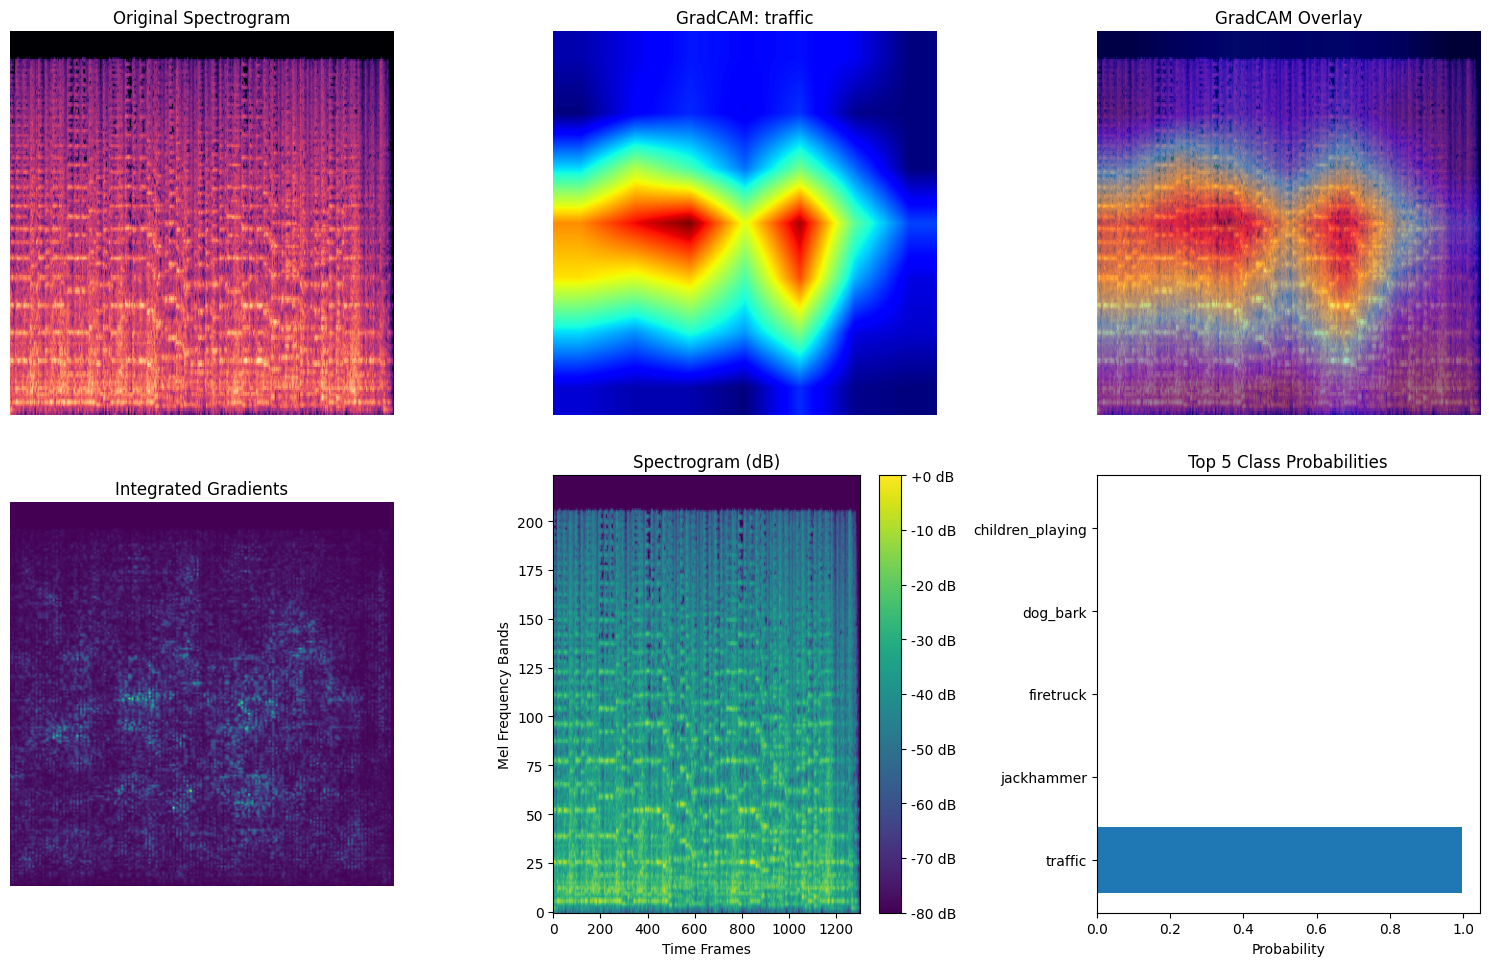

Audio sample:


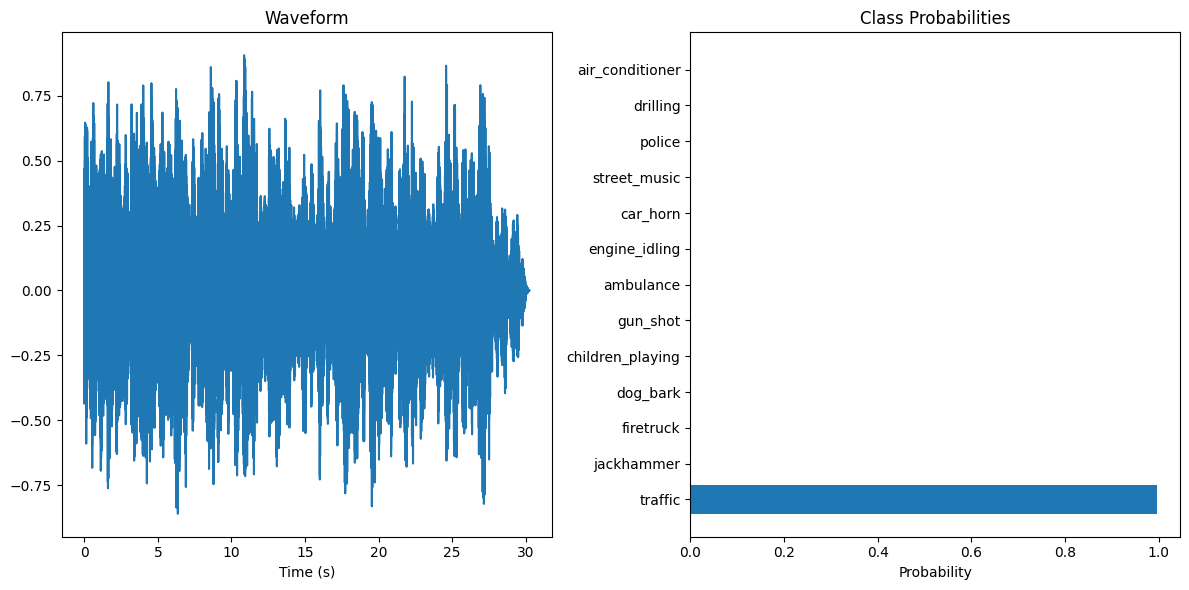


Final prediction: traffic with 99.61% confidence


In [7]:
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os
import IPython.display as ipd
import cv2

# Model Components (updated for MobileNetV3)
class ProjectionHead(torch.nn.Module):
    def __init__(self, input_dim=512, hidden_dim=512, output_dim=128):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.layers(x)

class SimCLR(torch.nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection = ProjectionHead()
    def forward(self, x):
        features = self.backbone(x)
        return self.projection(features)

class Classifier(torch.nn.Module):
    def __init__(self, input_dim=512, num_classes=13):
        super().__init__()
        self.fc = torch.nn.Linear(input_dim, num_classes)
    def forward(self, x):
        return self.fc(x)

def process_audio(audio_path, sr=22050, duration=None, n_mels=224):
    """Process audio to spectrogram (matches training config)"""
    y, sr = librosa.load(audio_path, sr=sr, duration=duration)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, 
                                      hop_length=512, n_mels=n_mels)
    S_dB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(4, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.axis('off')
    plt.tight_layout(pad=0)
    temp_path = 'temp_spec.png'
    plt.savefig(temp_path, bbox_inches='tight', pad_inches=0)
    plt.close()
    img = Image.open(temp_path).convert('RGB')
    if os.path.exists(temp_path):
        os.remove(temp_path)
    return img, y, sr, S_dB  # Return S_dB for additional visualizations

class AudioClassifier:
    def __init__(self, checkpoint_path, class_names, device=None):
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        # MobileNetV3-Small backbone matching training
        from torchvision.models import mobilenet_v3_small
        backbone = mobilenet_v3_small(weights=None)
        
        # Disable inplace operations for XAI compatibility
        for module in backbone.modules():
            if hasattr(module, 'inplace'):
                module.inplace = False
                
        backbone.classifier = torch.nn.Sequential(
            torch.nn.Linear(576, 512),
            torch.nn.Hardswish(inplace=False)  # Explicitly disable inplace
        )

        self.backbone = backbone
        self.simclr = SimCLR(backbone).to(self.device)
        self.classifier = Classifier().to(self.device)
        self.class_names = class_names

        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        self.simclr.load_state_dict(checkpoint['simclr'], strict=False)
        self.classifier.load_state_dict(checkpoint['classifier'], strict=False)

        self.simclr.eval()
        self.classifier.eval()

        # Input transforms matching training
        self.transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        
        # Set up hooks for GradCAM
        self.activations = None
        self.gradients = None
        self.setup_gradcam_hooks()
        
    def setup_gradcam_hooks(self):
        """Set up hooks for GradCAM visualization"""
        # Target the last convolutional layer in MobileNetV3
        target_layer = self.backbone.features[-1][-1]
        
        def forward_hook(module, input, output):
            self.activations = output.detach().clone()
            
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach().clone()
            
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_full_backward_hook(backward_hook)
    
    def generate_gradcam(self, img_tensor, target_class=None):
        """Generate GradCAM visualization for the input image"""
        # Forward pass
        self.simclr.zero_grad()
        features = self.simclr.backbone(img_tensor)
        logits = self.classifier(features)
        
        # If target class is not specified, use the predicted class
        if target_class is None:
            target_class = torch.argmax(logits, dim=1).item()
        
        # Backward pass to get gradients
        logits[0, target_class].backward(retain_graph=True)
        
        # Compute weights using gradients
        pooled_gradients = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        
        # Weight the activations by the gradients
        heatmap = torch.sum(pooled_gradients * self.activations, dim=1).squeeze()
        heatmap = torch.relu(heatmap)  # ReLU to only show positive contributions
        
        # Normalize heatmap
        if torch.max(heatmap) > 0:
            heatmap /= torch.max(heatmap)
            
        return heatmap.cpu().numpy(), target_class
    
    def compute_integrated_gradients(self, img_tensor, target_class=None, steps=50):
        """Compute Integrated Gradients for the input image"""
        # Create baseline (black image)
        baseline = torch.zeros_like(img_tensor).to(self.device)
        
        # Forward pass to get prediction
        self.simclr.zero_grad()
        features = self.simclr.backbone(img_tensor)
        logits = self.classifier(features)
        
        # If target class is not specified, use the predicted class
        if target_class is None:
            target_class = torch.argmax(logits, dim=1).item()
        
        # Compute integrated gradients
        integrated_grads = torch.zeros_like(img_tensor).to(self.device)
        
        for step in range(1, steps + 1):
            # Interpolate between baseline and input
            interpolated = baseline + (img_tensor - baseline) * (step / steps)
            interpolated.requires_grad = True
            
            # Forward pass
            features = self.simclr.backbone(interpolated)
            logits = self.classifier(features)
            
            # Backward pass
            self.simclr.zero_grad()
            logits[0, target_class].backward(retain_graph=True)
            
            # Get gradients
            gradients = interpolated.grad.detach()
            
            # Add to integrated gradients
            integrated_grads += gradients / steps
        
        # Multiply by input - baseline
        integrated_grads *= (img_tensor - baseline)
        
        # Sum across color channels for visualization
        attribution_map = torch.sum(torch.abs(integrated_grads), dim=1).squeeze()
        
        # Normalize for visualization
        if torch.max(attribution_map) > 0:
            attribution_map /= torch.max(attribution_map)
            
        return attribution_map.cpu().numpy(), target_class
    
    def predict(self, audio_path, verbose=True, visualize_xai=True):
        """Predict class for audio file with XAI visualizations"""
        if verbose:
            print(f"Processing audio: {audio_path}")
            
        # Process audio to spectrogram
        img, audio, sr, S_dB = process_audio(audio_path)
        img_tensor = self.transform(img).unsqueeze(0).to(self.device)
        
        # Get predictions
        with torch.no_grad():
            features = self.simclr.backbone(img_tensor)
            logits = self.classifier(features)
            probs = torch.nn.functional.softmax(logits, dim=1).squeeze().cpu().numpy()
        
        # Print top predictions
        if verbose:
            top_indices = np.argsort(probs)[::-1][:3]
            print("\nTop 3 predictions:")
            for i, idx in enumerate(top_indices):
                print(f"{i+1}. {self.class_names[idx]}: {probs[idx]*100:.2f}%")
        
        # Generate XAI visualizations
        if visualize_xai:
            self.visualize_xai(img, img_tensor, probs, S_dB)
            
        return probs, audio, sr

    def visualize_xai(self, original_img, img_tensor, probs, spectrogram_db):
        """Generate and display multiple XAI visualizations"""
        # Get top predicted class
        top_class = np.argmax(probs)
        
        # 1. GradCAM visualization
        gradcam_heatmap, _ = self.generate_gradcam(img_tensor, top_class)
        
        # 2. Integrated Gradients visualization
        ig_heatmap, _ = self.compute_integrated_gradients(img_tensor, top_class)
        
        # Resize heatmaps to match original image
        original_size = (original_img.width, original_img.height)
        gradcam_heatmap_resized = cv2.resize(gradcam_heatmap, original_size)
        ig_heatmap_resized = cv2.resize(ig_heatmap, original_size)
        
        # Convert heatmaps to RGB for visualization
        gradcam_heatmap_rgb = cv2.applyColorMap(np.uint8(255 * gradcam_heatmap_resized), cv2.COLORMAP_JET)
        gradcam_heatmap_rgb = cv2.cvtColor(gradcam_heatmap_rgb, cv2.COLOR_BGR2RGB)
        
        # Create overlay images
        original_img_np = np.array(original_img)
        gradcam_overlay = cv2.addWeighted(original_img_np, 0.6, gradcam_heatmap_rgb, 0.4, 0)
        
        # Create figure for visualization
        plt.figure(figsize=(15, 10))
        
        # 1. Original spectrogram
        plt.subplot(2, 3, 1)
        plt.imshow(original_img)
        plt.title("Original Spectrogram")
        plt.axis('off')
        
        # 2. GradCAM heatmap
        plt.subplot(2, 3, 2)
        plt.imshow(gradcam_heatmap_resized, cmap='jet')
        plt.title(f"GradCAM: {self.class_names[top_class]}")
        plt.axis('off')
        
        # 3. GradCAM overlay
        plt.subplot(2, 3, 3)
        plt.imshow(gradcam_overlay)
        plt.title("GradCAM Overlay")
        plt.axis('off')
        
        # 4. Integrated Gradients heatmap
        plt.subplot(2, 3, 4)
        plt.imshow(ig_heatmap_resized, cmap='viridis')
        plt.title("Integrated Gradients")
        plt.axis('off')
        
        # 5. Frequency-Time Analysis
        plt.subplot(2, 3, 5)
        plt.imshow(spectrogram_db, aspect='auto', origin='lower', cmap='viridis')
        plt.colorbar(format='%+2.0f dB')
        plt.title("Spectrogram (dB)")
        plt.xlabel('Time Frames')
        plt.ylabel('Mel Frequency Bands')
        
        # 6. Class Probability Distribution
        plt.subplot(2, 3, 6)
        top_indices = np.argsort(probs)[::-1][:5]  # Show top 5 classes
        plt.barh([self.class_names[i] for i in top_indices], 
                 [probs[i] for i in top_indices])
        plt.title("Top 5 Class Probabilities")
        plt.xlabel("Probability")
        
        plt.tight_layout()
        plt.show()

# Visualization function remains unchanged
def visualize_prediction(probs, audio, sr, class_names):
    print("Audio sample:")
    display(ipd.Audio(audio, rate=sr))
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(np.linspace(0, len(audio)/sr, len(audio)), audio)
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.subplot(1, 2, 2)
    indices = np.argsort(probs)[::-1]
    plt.barh(range(len(class_names)), [probs[i] for i in indices])
    plt.yticks(range(len(class_names)), [class_names[i] for i in indices])
    plt.title("Class Probabilities")
    plt.xlabel("Probability")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    class_names = ['air_conditioner', 'car_horn', 'children_playing', 
                  'dog_bark', 'drilling', 'engine_idling', 
                  'gun_shot', 'jackhammer', 'ambulance', 'firetruck', 'police', 'traffic', 'street_music']
    classifier = AudioClassifier(
        checkpoint_path='fold_10_checkpoint.pth',
        class_names=class_names
    )
    audio_path = "./TestAudioFiles/starwars.wav"
    probs, audio, sr = classifier.predict(audio_path)
    visualize_prediction(probs, audio, sr, class_names)
    top_idx = np.argmax(probs)
    print(f"\nFinal prediction: {class_names[top_idx]} with {probs[top_idx]*100:.2f}% confidence")
